In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

%matplotlib inline

In [2]:
#export
from exp.petrinet import *
import random
import string

In [3]:
#export
def decision(probability):
    return random.random() < probability

    
def get_random_simple_grammar(n, l, hn=0.1, rec=0.1, drec=0.1, c=0.1, max_in_layer=None):
    #n=nodes
    #l=layers
    
    #PARAMS
    grammar , reclink = [], []
    edge = '->'
    start, end = None, None
    layers = {}
    current_index, max_index_in_layer = 0, 0
    keys = [x for x in range(l)]   
    random.shuffle(keys)
    
    
    #SET MAX NUMBER OF NODES IN LAYER
    if l>n:l=n
    if max_in_layer:max_in_layer=max_in_layer
    else: max_in_layer = int(n/l)+1
    
    
    #CREATE NODE NAMES
    f = int(n/26)+1
    alph = string.ascii_uppercase
    alphabet = []
    if f > 1:
        for i in range(0,n):
            x = int(i/26)
            j = i
            if i > 25: j = i - (26*x) 
            node=alph[j]
            if x == 0:alphabet.append(node)
            else:alphabet.append("%s%s" % (node,x))
    else: alphabet = list(string.ascii_uppercase[0:n])
    r = len(alphabet)
    
    
    #DIVIDE NODE INDICES OVER NETWORK LAYERS
    for i, j in enumerate(keys):
        maxnodes = r - (l-i) + 1
        nodes = random.randrange(1, maxnodes+1)
        if nodes > max_in_layer: nodes = max_in_layer
        if i == l-1: nodes = r
        #max_index_in_layer = max_index_in_layer + nodes
        layers[j] = nodes#alphabet[current_index:max_index_in_layer]
        #current_index = max_index_in_layer
        r = r - nodes
        
    i=0
    for k in sorted(layers):
        v=i+layers[k]
        layers[k]=alphabet[i:v]
        i=v  
        
    
    #INSERT HIDDEN NODES BASED ON PROBABILITY hn
    i=1
    while decision(hn):
        layers[random.randint(0,l-1)].append('_%s' % str(i))
        i+=1
        
        
    #CREATE "STANDARD" EDGES BETWEEN LAYERS
    for k, v in layers.items():
        element = ','.join(v)
        if k == 0: 
            start = edge+element
        else:             
            prev_element = ','.join(layers[k-1])
            grammar.append(prev_element + edge + element)            
        if k == l-1: end = element+edge
            
            
    #INSERT CROSSCONNECTIONS BETWEEN RANDOM NODES BASED ON PROBABILITY c  
    while decision(c):
        cc = []
        j = random.randint(1, n)
        nodes = []
        for k in range(j):
            node = random.choice(alphabet)
            if node not in nodes: nodes.append(node)
        if len(nodes) > 1:        
            nodes.insert(random.randint(1,len(nodes)-1), edge)        
            word = ','.join(nodes).replace(',-', '-').replace('>,', '>')
            grammar.append(word)
            
            
    #INSERT RECURRENT CONNECTIONS BETWEEN NODES BASED ON PROBABILITY rec        
    while decision(rec):
        nodes = []
        i = random.randint(0, len(alphabet)-1)
        node = alphabet[i]
        if node not in nodes: nodes.append(node)
        #INSERT DOUBLE RECURRENT CONNECTION BASED ON PROBABILITY drec
        while decision(drec):
            j = random.randint(0, len(alphabet)-1)
            node = alphabet[j]
            if node not in nodes:nodes.append(node)    
        word = ','.join(nodes)
        word = word+edge+word
        if word not in reclink: reclink.append(word)
    if len(reclink) > 0: 
        for x in reclink : grammar.append(x)
            
    
    #INSERT THE START AND END NODES
    grammar.insert(0, start)
    grammar.append(end)
    
    return grammar

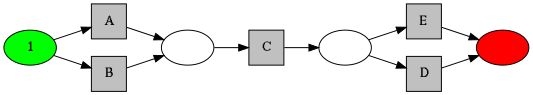

In [9]:
rsg = get_random_simple_grammar(5, 3, hn=0.1, rec=0.05, drec=0.15, c=0.7, max_in_layer=None)
pn = PetriNet.from_simple_grammar(rsg)
display(pn.view())